# London POI Data Preparation

POI data is from Foursquare.

## 1. Import Libraries

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import re
import matplotlib.font_manager as fm

## 2. Load POI Data

In [52]:
# Read in unclipped London POI data
fs_london_unclipped = gpd.read_file("../../data/london/fs_london.csv")

# Import Greater London glx towns
glondon_seamless = gpd.read_file("../../data/london/glondon_seamless.gpkg")
# Set CRS
glondon_seamless.crs = "EPSG:4326"

## 3. Data Cleaning

In [53]:
# Remove square brackets from the category label strings
category_strings = fs_london_unclipped['fsq_category_labels'].str.strip('[]')

# Replace commas with ' > ' to indicate category hierarchy
category_strings = category_strings.str.replace(r'\s*,\s*', ' > ', regex=True)

# Replace empty strings with NaN
category_strings = category_strings.replace('', np.nan)

# Split the hierarchy into separate columns (one per level)
categories_df = category_strings.str.split(' > ', expand=True)

# Ensure there are exactly 15 columns (pad with NaNs if fewer)
required_columns = list(range(15))
categories_df = categories_df.reindex(columns=required_columns)

# Rename columns to level1_category, level2_category, ..., level15_category
new_column_names = {i: f'level{i+1}_category' for i in range(15)}
categories_df = categories_df.rename(columns=new_column_names)

# Concatenate the new category levels back to the original dataframe
fs_london_unclipped = pd.concat([fs_london_unclipped, categories_df], axis=1)

In [54]:
# Keep only the columnes needed
fs_london_unclipped = fs_london_unclipped[["fsq_place_id", "name", "post_town", "fsq_category_labels", "latitude", "longitude", "address", "level1_category", "level2_category", "level3_category", "level4_category", "level5_category", "level6_category", "level7_category", "level8_category", "level9_category", "level10_category", "level11_category", "level12_category", "level13_category", "level14_category", "level15_category"]]

In [55]:
# Convert to geoDF
fs_london_unclipped["geometry"] = gpd.points_from_xy(fs_london_unclipped["longitude"], fs_london_unclipped["latitude"])
fs_london_unclipped = gpd.GeoDataFrame(fs_london_unclipped, geometry="geometry")

# Set CRS
fs_london_unclipped.crs = "EPSG:4326"

In [56]:
# Clip POIs to London boundary
fs_london_clipped = gpd.sjoin(fs_london_unclipped, glondon_seamless, predicate = "within")

## 4. Data Exploration

/var/folders/1n/_7fnqrv504n3tlnbg2hqgkdh0000gn/T/ipykernel_5615/2594035154.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


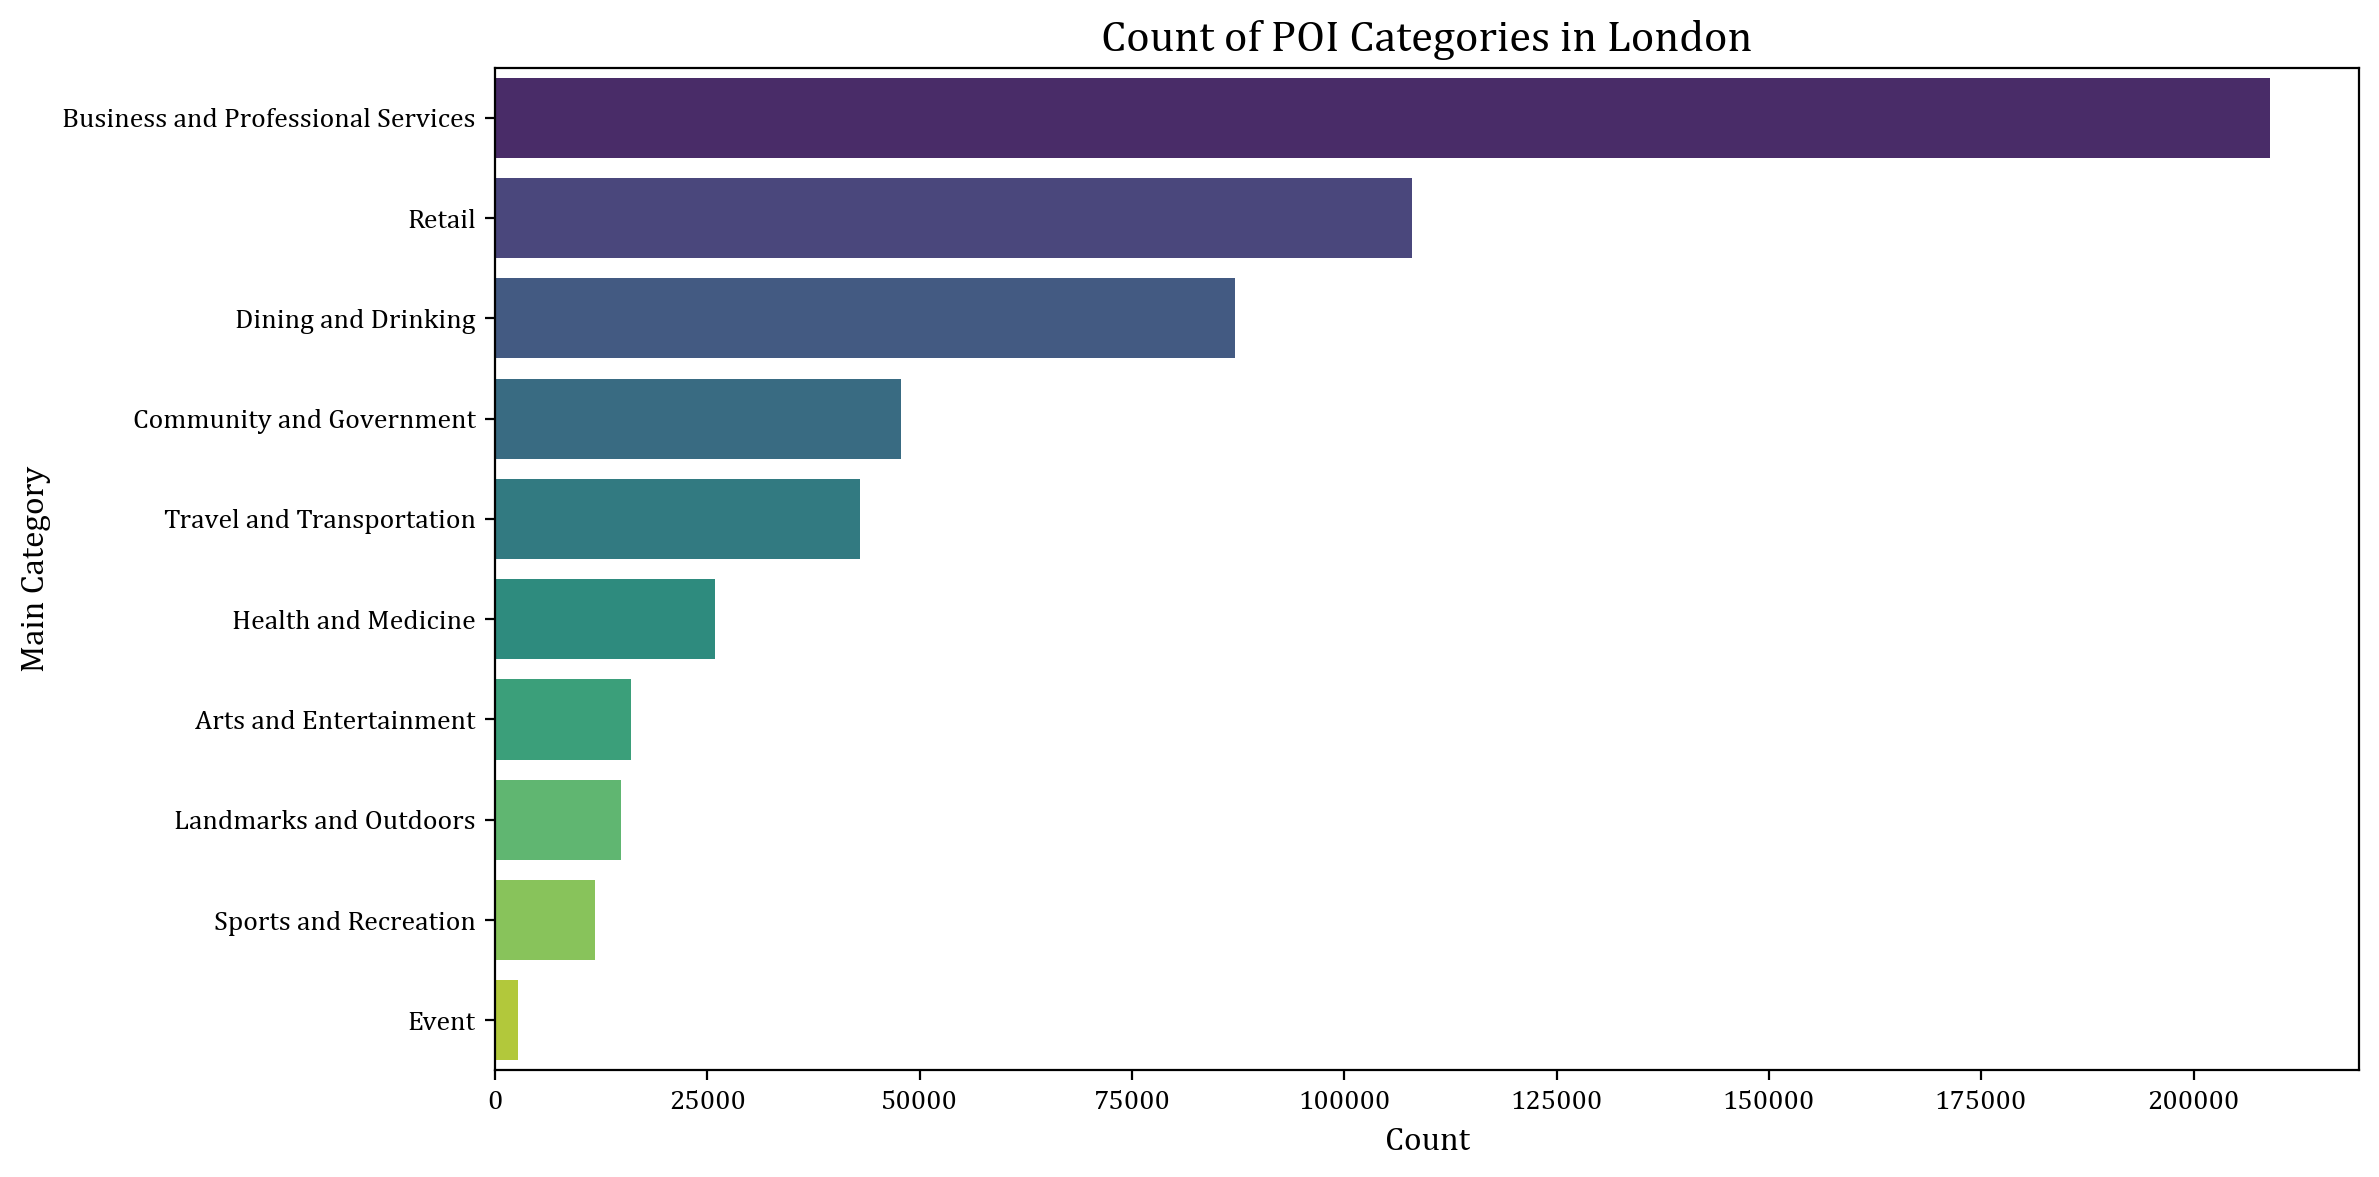

In [9]:
# Load custom font
cambria_path = "/Library/Fonts/Microsoft/Cambria.ttf" 
cambria_prop = fm.FontProperties(fname=cambria_path)

# Create the plot
#sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=fs_london_clipped,
    y="level1_category",
    order=fs_london_clipped["level1_category"].value_counts().index,
    palette="viridis"
)

# Set custom font on each text element
plt.title("Count of POI Categories in London", fontproperties=cambria_prop, fontsize=16)
plt.xlabel("Count", fontproperties=cambria_prop, fontsize=12)
plt.ylabel("Main Category", fontproperties=cambria_prop, fontsize=12)

# Update tick labels to use the font
for label in ax.get_xticklabels():
    label.set_fontproperties(cambria_prop)
for label in ax.get_yticklabels():
    label.set_fontproperties(cambria_prop)

plt.tight_layout()
plt.show()

## 5. Aggregate POIs to Towns

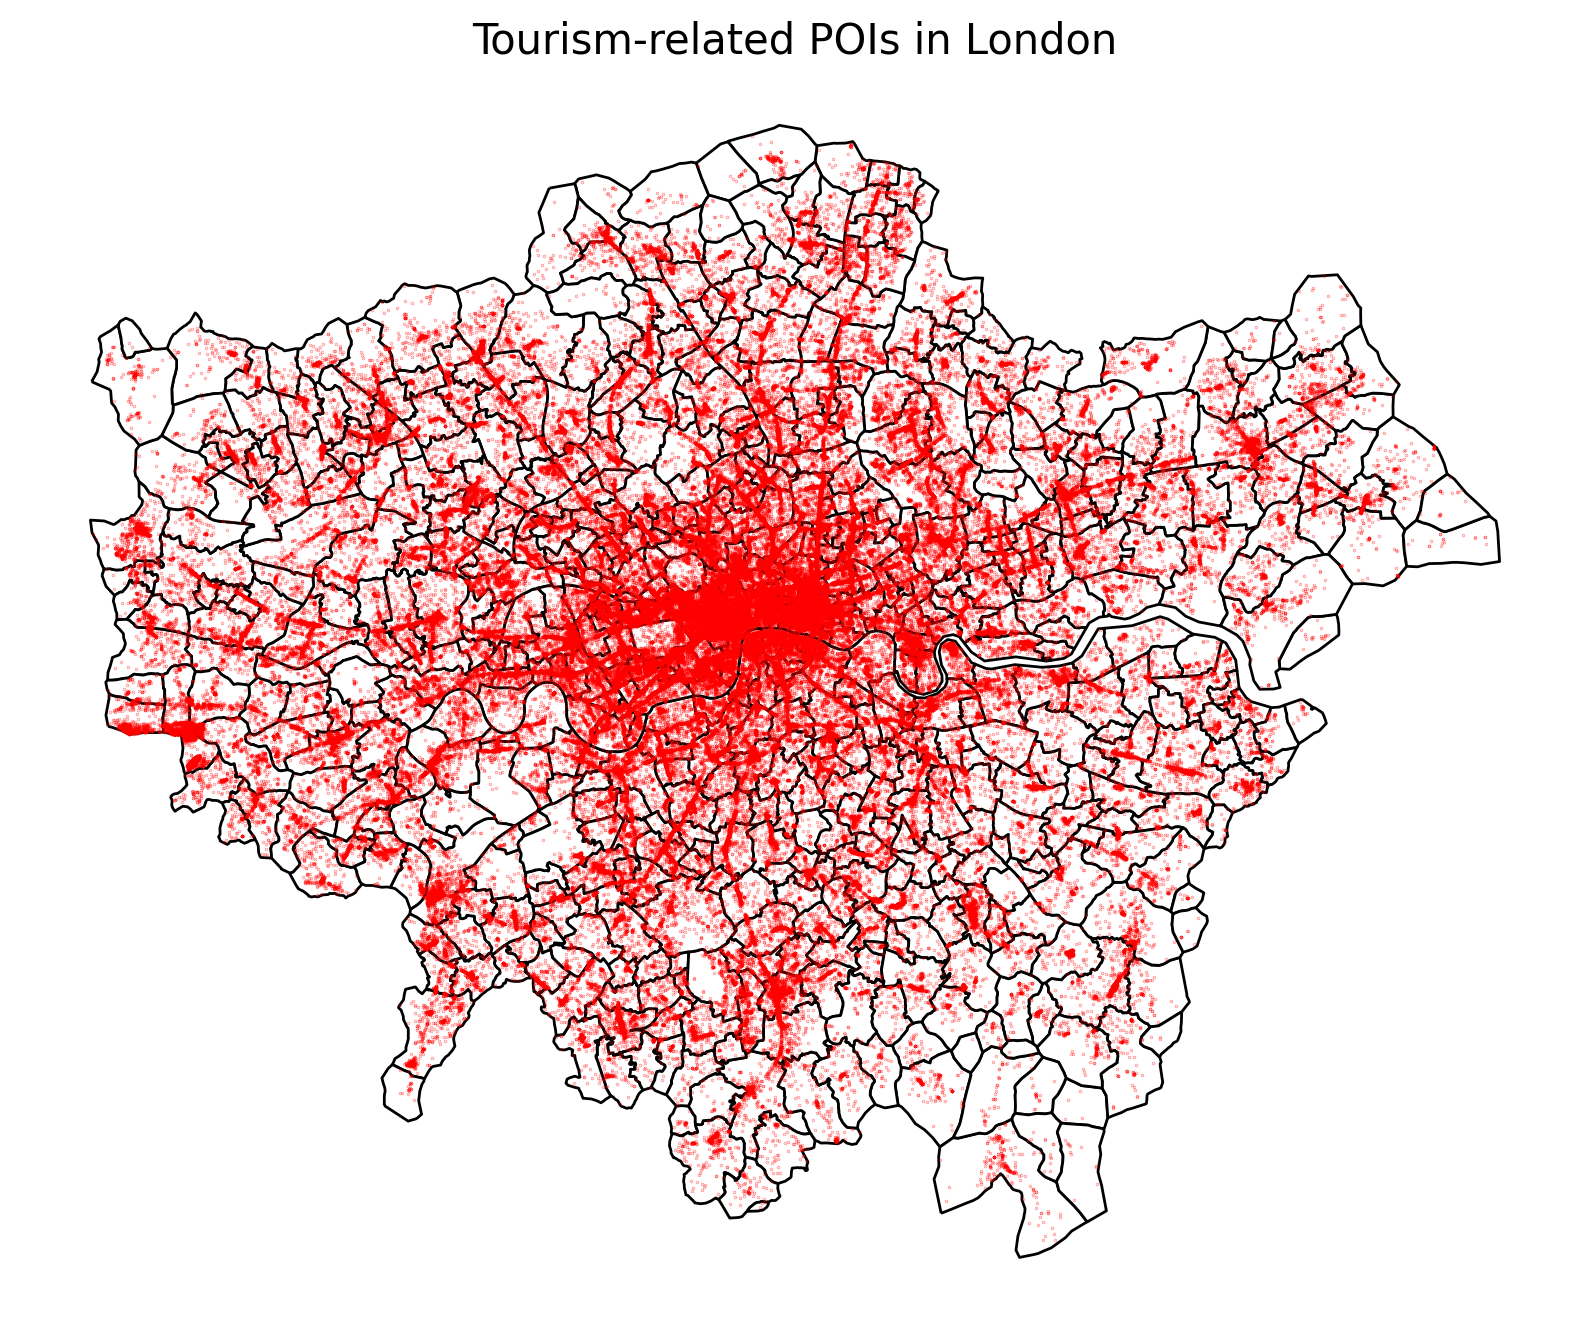

In [57]:
# Plot town boundaries
ax = glondon_seamless.plot(figsize = (10,10), color = "white", edgecolor="black")
# Plot poi points
london_tourism_pois.plot(ax = ax, color = "red", markersize = 0.05, alpha = 0.5)

ax.set_title("Tourism-related POIs in London", fontsize = 15)
ax.set_axis_off()

In [58]:
# Drop sjoin artifacts if they exist
for df in [fs_london_clipped, glondon_seamless]:
    if 'index_right' in df.columns:
        df.drop(columns = 'index_right', inplace = True)

# Count POIs per area and category
glondon_fs_cat_count = (
    fs_london_clipped.groupby(['id', 'level1_category'])
    .size()
    .reset_index(name = 'count')
)

# Pivot to wide format
glondon_fs_cat_count_pivot = glondon_fs_cat_count.pivot_table(
    index = 'id',
    columns = 'level1_category',
    values = 'count',
    fill_value=0
).reset_index()

# Merge counts with geometry
fs_london_counts = glondon_seamless.merge(glondon_fs_cat_count_pivot, on = 'id', how = 'left')
fs_london_counts.fillna(0, inplace = True)

# Calculate total POIs per area
fs_london_counts_cols = glondon_fs_cat_count_pivot.columns.difference(['id'])
fs_london_counts['total_pois'] = fs_london_counts[fs_london_counts_cols].sum(axis = 1)

# Calculate proportions
for col in fs_london_counts_cols:
    fs_london_counts[f'{col}_count'] = fs_london_counts[col]
    fs_london_counts[f'{col}_proportion'] = fs_london_counts[col] / fs_london_counts['total_pois'].replace(0, pd.NA)

# Reproject to British National Grid for accurate area calculation
fs_london_counts = fs_london_counts.to_crs(epsg=27700)

# Calculate area and density
fs_london_counts['area_km2'] = fs_london_counts.geometry.area / 1e6

for col in fs_london_counts_cols:
    fs_london_counts[f'{col}_density'] = fs_london_counts[col] / fs_london_counts['area_km2'].replace(0, pd.NA)

# Drop raw category cols
fs_london_counts.drop(columns = fs_london_counts_cols, inplace = True)

# Get log values for all columns
# Identify all count, proprotion, and density columns
fs_log_targets = [col for col in fs_london_counts.columns if col.endswith(('_count', '_proportion', '_density'))]

# Log-transform
for col in fs_log_targets:
    log_col = f'{col}_log'
    fs_london_counts[log_col] = np.log1p(pd.to_numeric(fs_london_counts[col], errors='coerce').fillna(0))

/var/folders/1n/_7fnqrv504n3tlnbg2hqgkdh0000gn/T/ipykernel_5615/1506935054.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fs_london_counts.fillna(0, inplace = True)


In [59]:
# Identify the first 10 * _count_log columns
fs_london_count_log_cols = [col for col in fs_london_counts if col.endswith('_count_log')][:10]
# Identify the first 10 * _density_log columns
fs_london_density_log_cols = [col for col in fs_london_counts.columns if col.endswith('_density_log')][:10]
# Identify the first 10 * _proportion_log columns
fs_london_proportion_log_cols = [col for col in fs_london_counts.columns if col.endswith('_proportion_log')][:10]

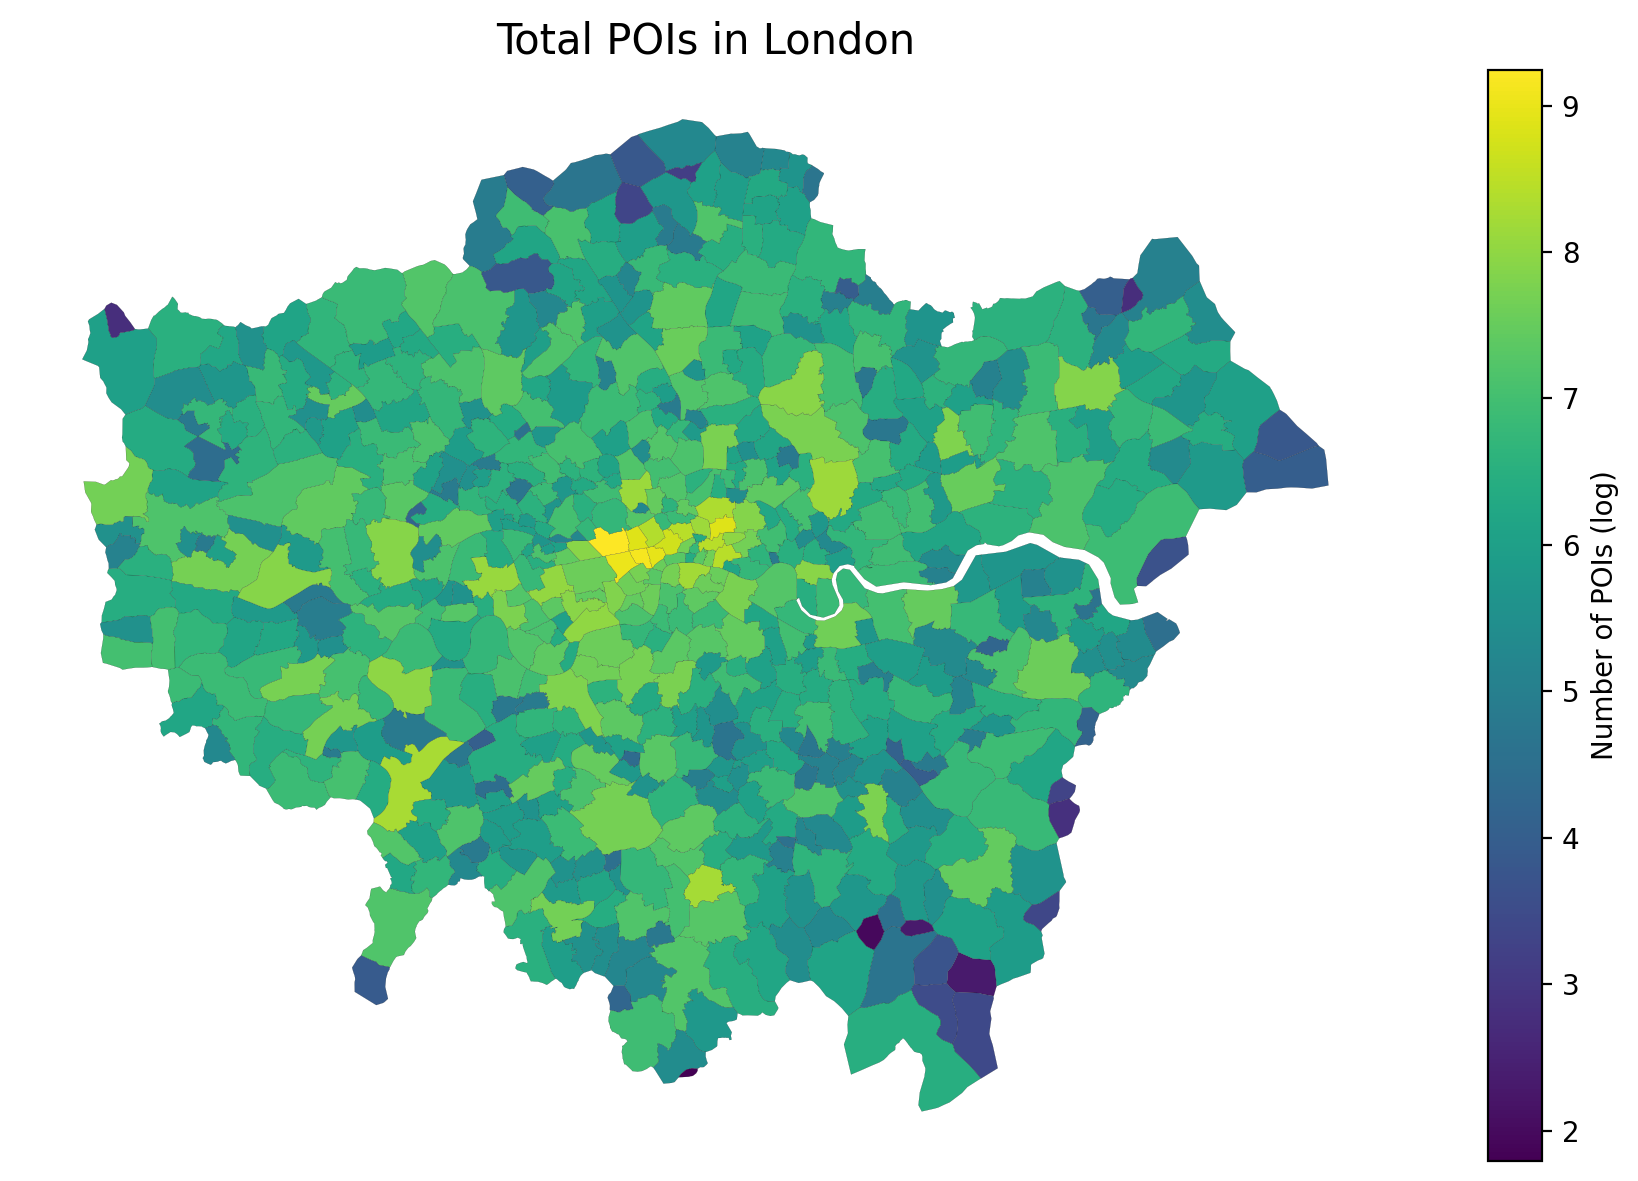

In [60]:
# log the total_pois column
fs_london_counts['total_pois_log'] = np.log1p(fs_london_counts['total_pois']+1)

# ---- Create graph for all POIs ----
fig, ax = plt.subplots(figsize=(10, 6))

fs_london_counts.plot(
    column='total_pois_log',
    cmap='viridis',
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.05,
    legend_kwds={'label': "Number of POIs (log)", 'orientation': "vertical"}
)
ax.set_title("Total POIs in London", fontsize=15)
ax.set_axis_off()
plt.tight_layout()
plt.show()

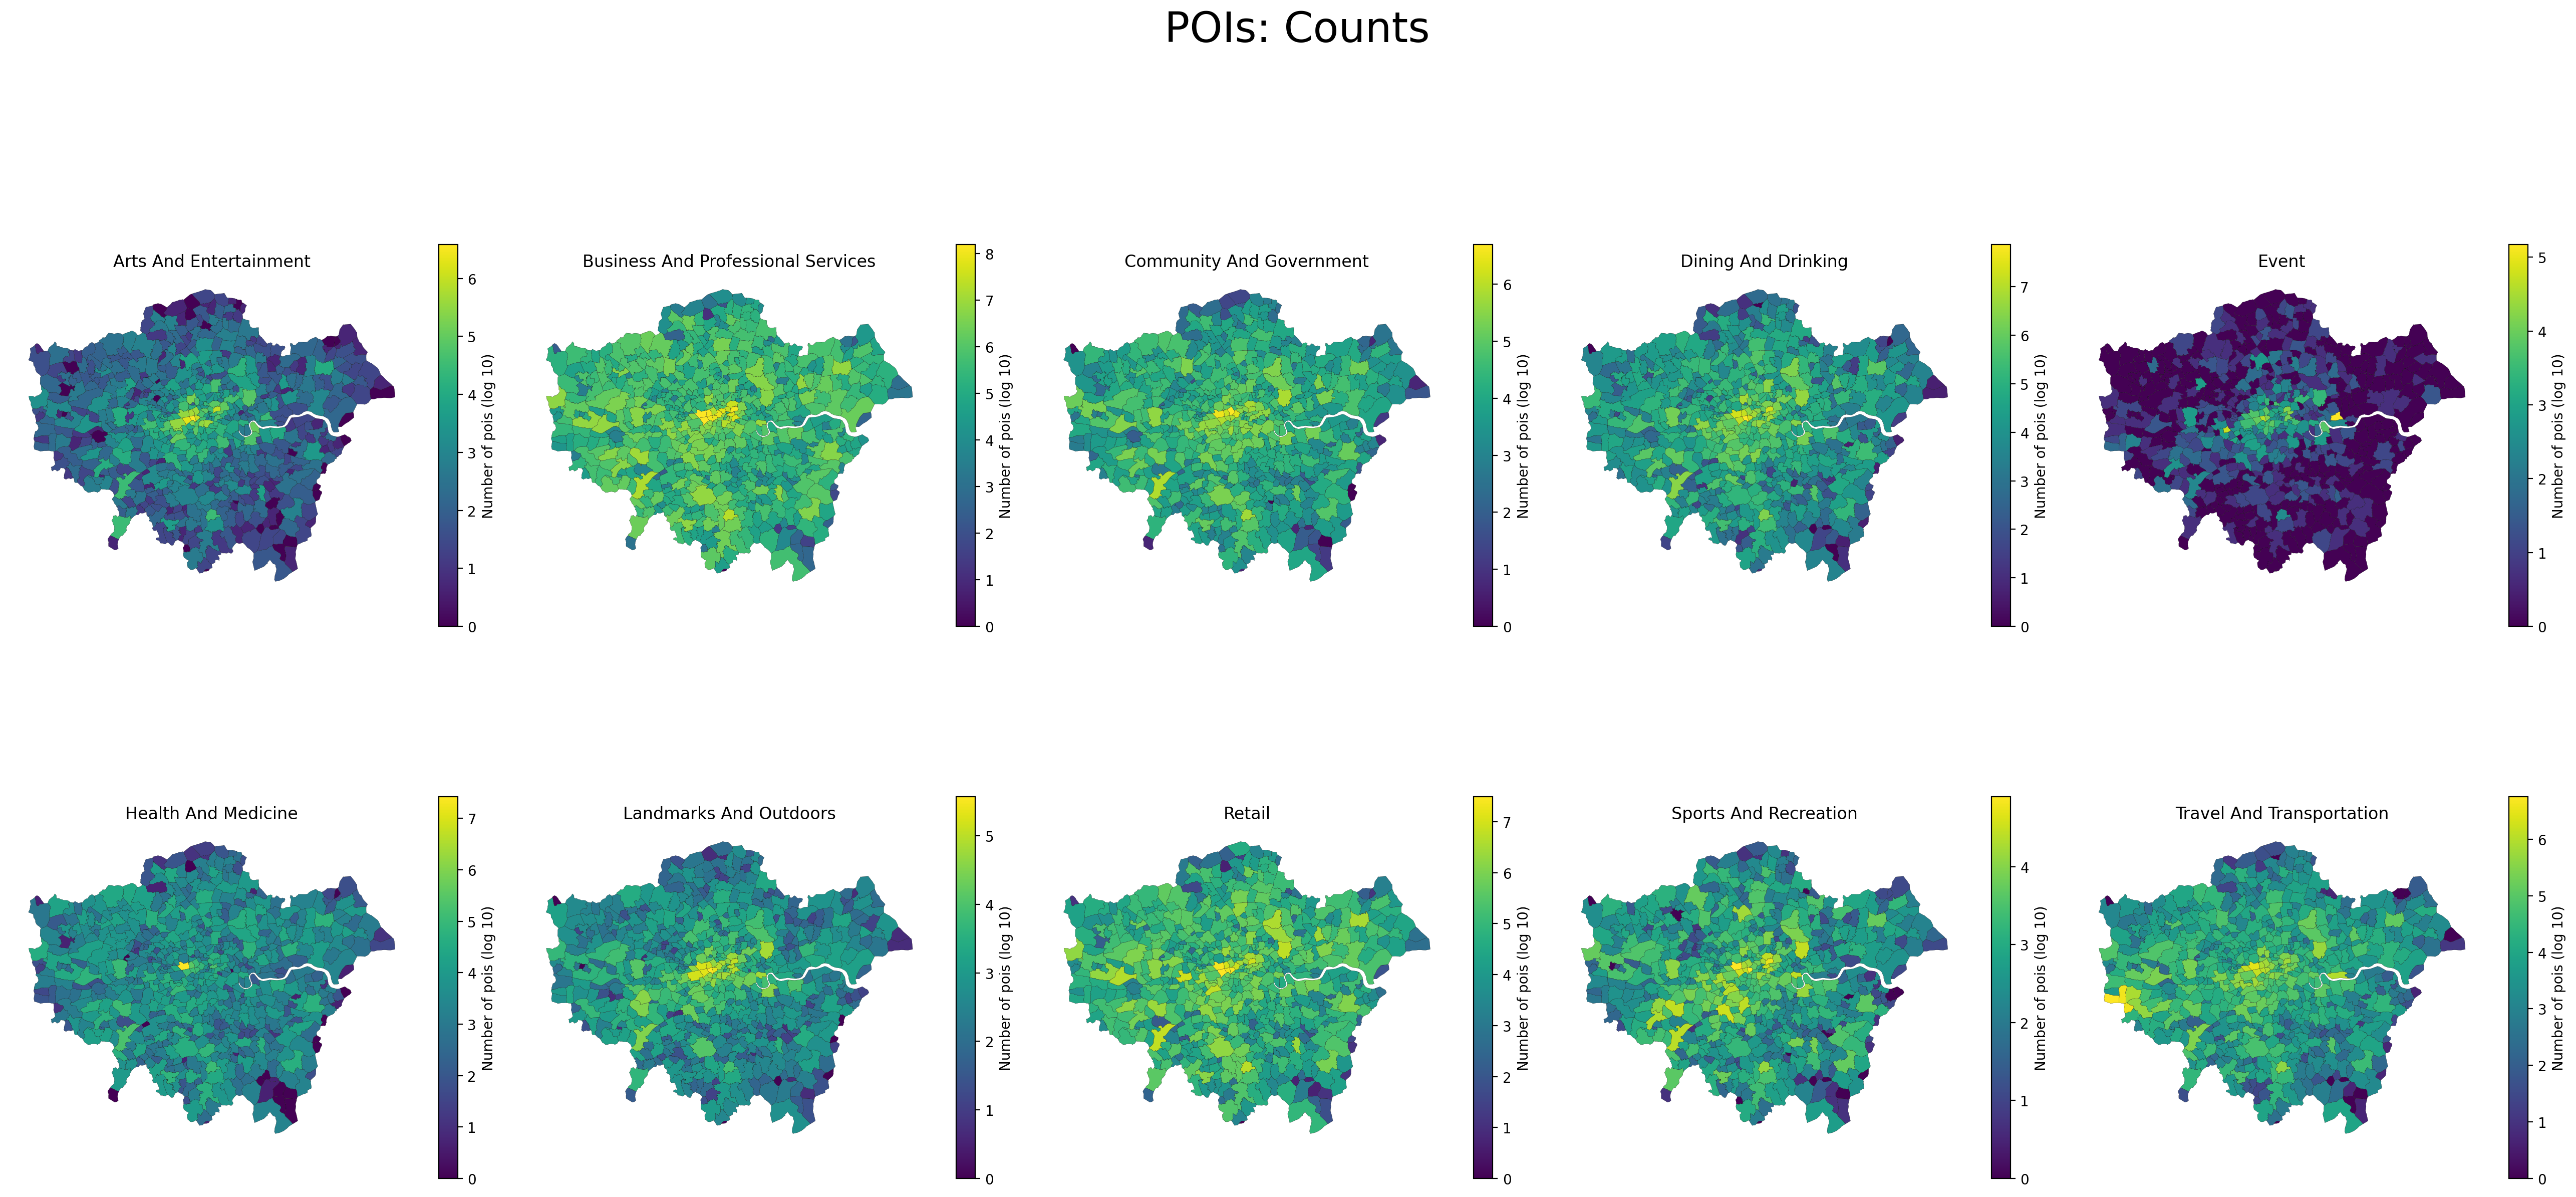

In [61]:
# ---- Create logged counts graph ----
# Create subplots (2 rows x 5 columns)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(26, 14))
axes = axes.flatten()

# Plot each category
for ax, col in zip(axes, fs_london_count_log_cols):
    fs_london_counts.plot(
        column=col,
        cmap='viridis',
        legend=True,
        edgecolor='black',
        linewidth=0.1,
        ax=ax,
        legend_kwds={"shrink": 0.5, "label": 'Number of pois (log 10)'},
    )
    ax.set_title(col.replace('_count_log', '').replace('_', ' ').title())
    ax.set_axis_off()

plt.suptitle("POIs: Counts", fontsize = 30)
plt.tight_layout()
plt.show()

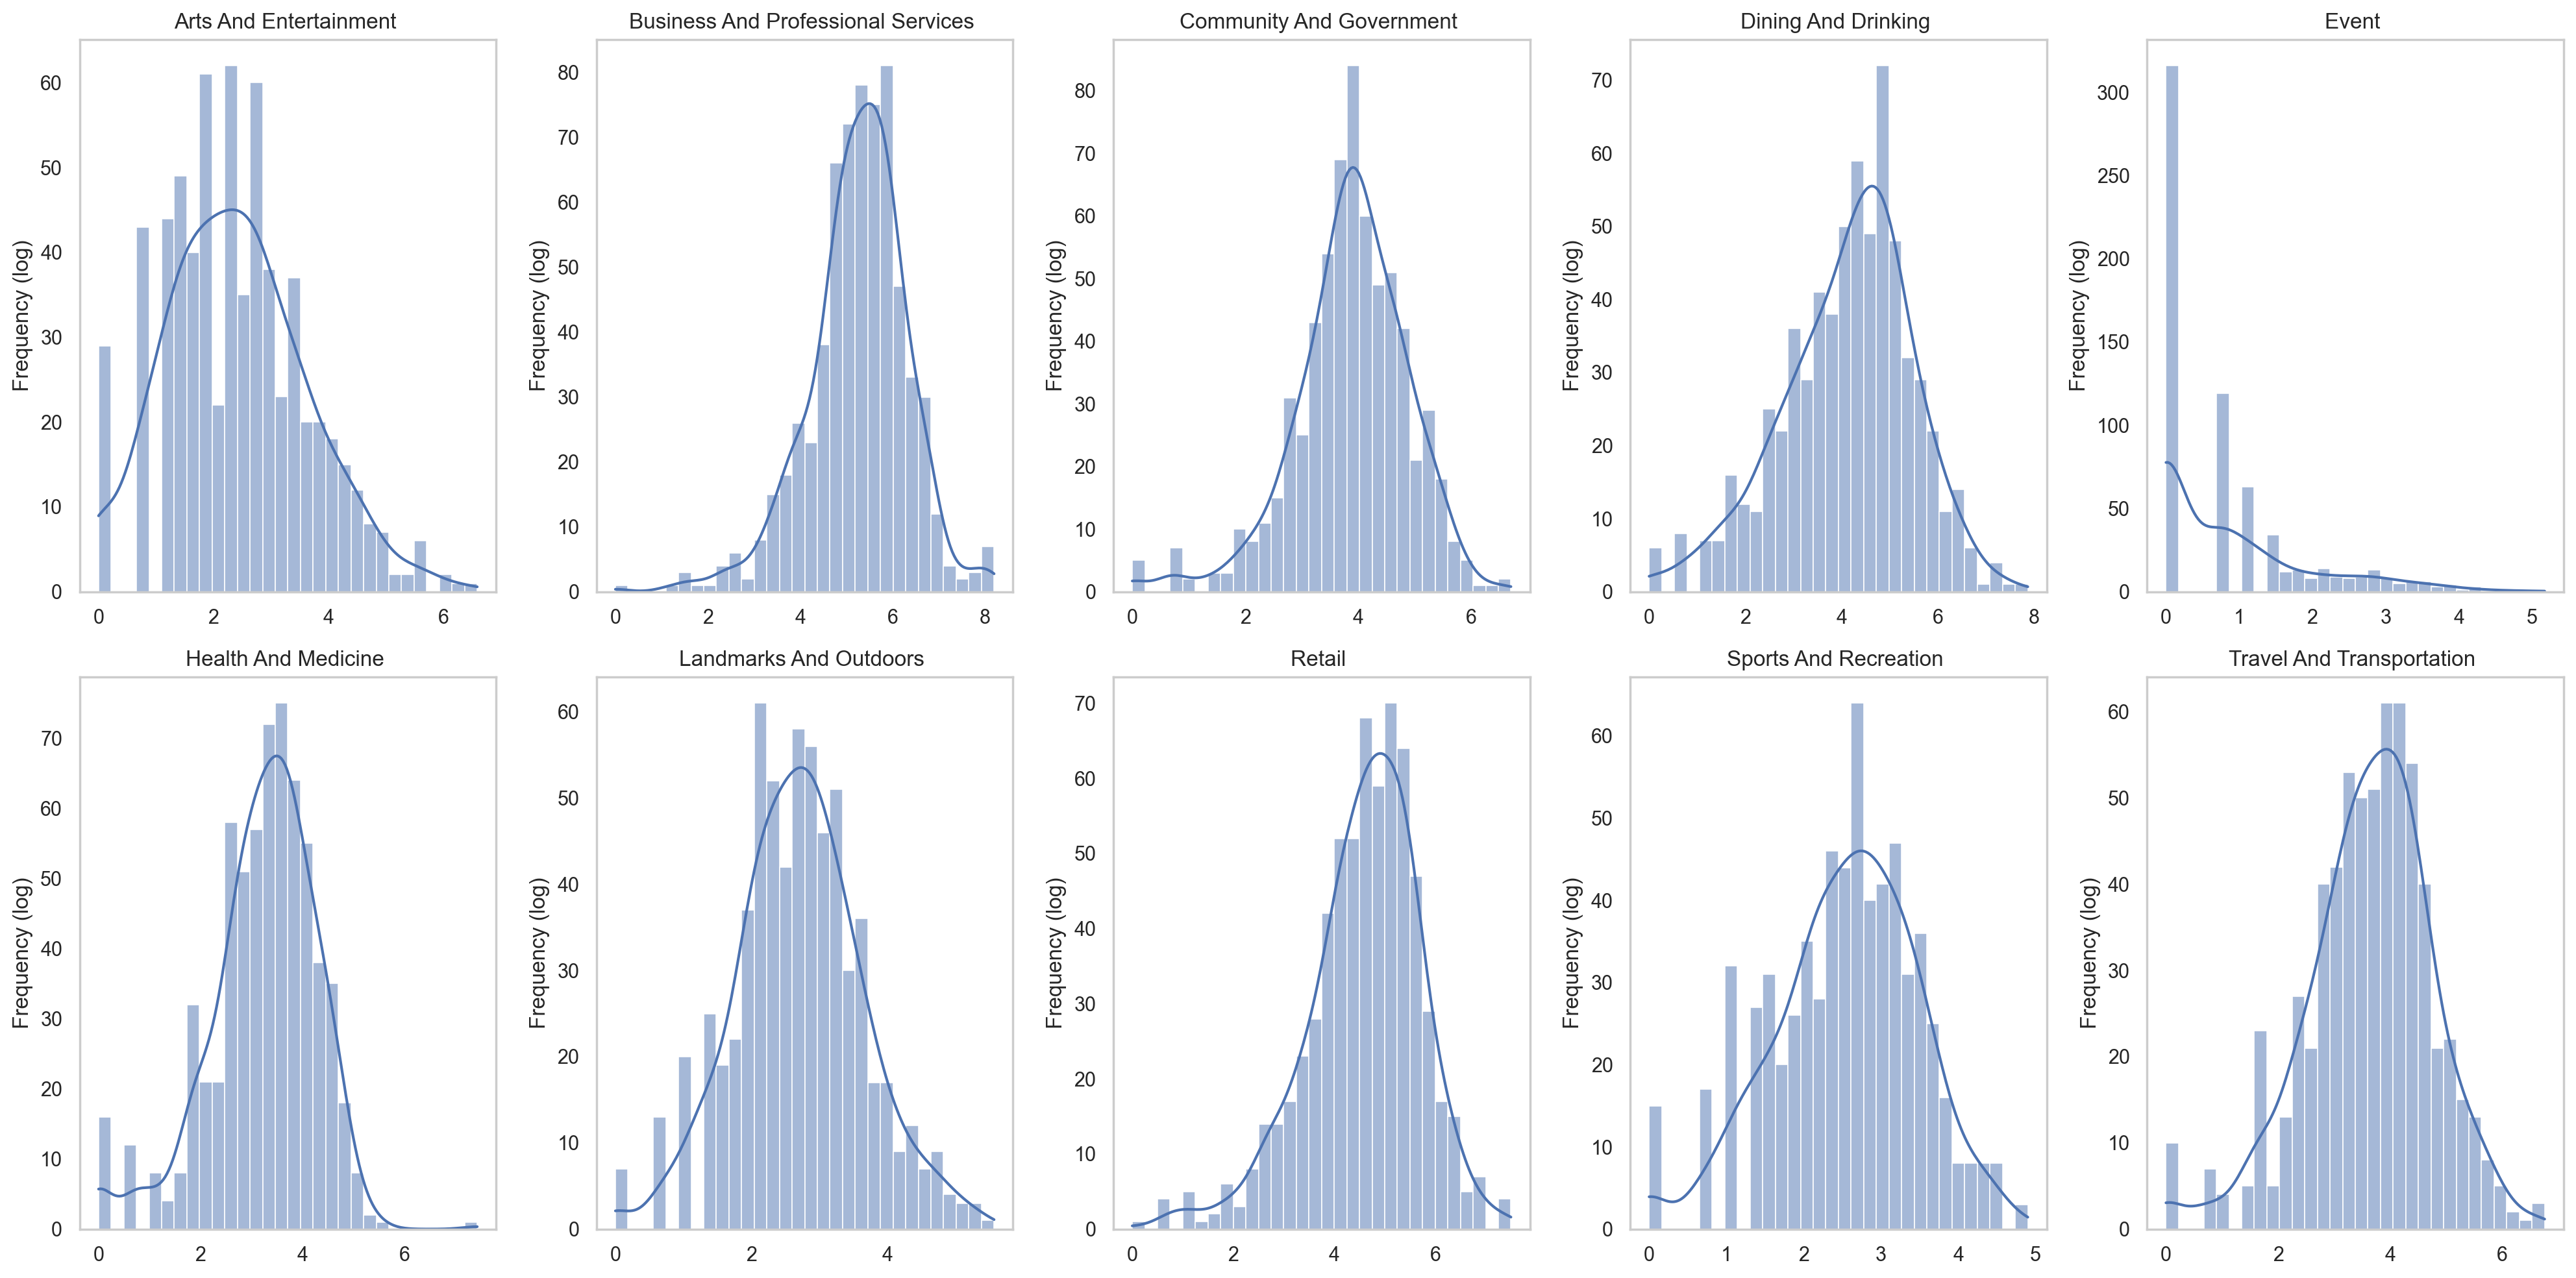

In [ ]:
import seaborn as sns

## Histograms
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
axes = axes.flatten()

for i, col in enumerate(fs_london_count_log_cols):
    sns.histplot(
        data = fs_london_counts,
        x = col,
        ax = axes[i],
        kde = True,
        color = '#4c72b0',
        edgecolor = 'white',
        bins = 30
    )
    axes[i].set_title(col.replace("_count_log", " ").replace('_', ' ').title())
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency (log)")
    axes[i].grid(False)

plt.tight_layout()
plt.show()

## 6. Refining Tourism-related POI Categories

In [62]:
tourism_categories = [
    "Arts and Entertainment", 
    "Dining and Drinking", 
    "Landmarks and Outdoors",
    "Retail",
    "Travel and Transportation",
    "id"
]

# Keep only tourism categories and others
london_tourism_pois = fs_london_clipped[fs_london_clipped["level1_category"].isin(tourism_categories)]

In [63]:
# Only keep relevant columns
london_tourism_pois = london_tourism_pois[[
    "fsq_place_id", "name", "post_town", 
    "latitude", "longitude", "address",
    "level1_category", "level2_category", "level3_category",
    "level4_category", "level5_category", "level6_category",
    "level7_category", "level8_category", "level9_category",
    "level10_category", "level11_category", "level12_category",
    "level13_category", "level14_category", "level15_category",
    "id",
    "geometry"
]]

### Create Unified Search Column

In [64]:
# Select all the category level columns that exist
level_cols = [f'level{i}_category' for i in range(1, 16)]
existing_level_cols = [col for col in level_cols if col in london_tourism_pois.columns]

# Also include the name and fsq_category_labels
search_cols = ['name'] + existing_level_cols

# Fill amy missing values (NaN) with empty strings
london_tourism_pois[search_cols] = london_tourism_pois[search_cols].fillna('')

# Join them all into a single, lowercase string
london_tourism_pois['search_corpus'] = london_tourism_pois[search_cols].apply(lambda row: ' '.join(row).lower(), axis=1)

london_tourism_pois['search_corpus'].head().tolist()

['the quick landmarks and outdoors campground             ',
 'kiddicare retail miscellaneous store             ',
 'blooms the florist retail flower store             ',
 'city roofing contracts retail construction supplies store             ',
 'phones 4u retail computers and electronics retail mobile phone store            ']

### Dining and Drinking

In [65]:
# Filter the dataframe to only include 'Dining & Drinking' POIs
dining_df = london_tourism_pois[london_tourism_pois['level1_category'] == 'Dining and Drinking'].copy()

# Get all the unique sub-categories from Level 2 and Level 3 for dining
unique_level2_dining = dining_df['level2_category'].unique().tolist()
unique_level3_dining = dining_df['level3_category'].unique().tolist()

# Print them out in a clean format
print("--- Unique Level 2 Dining Categories ---")
print(unique_level2_dining)
print("\n" + "="*40 + "\n") # Separator
print("--- Unique Level 3 Dining Categories ---")
print(unique_level3_dining)

--- Unique Level 2 Dining Categories ---
['Restaurant', 'Cafe', 'Bakery', 'Dessert Shop', 'Breakfast Spot', 'Bar', 'Bagel Shop', 'Snack Place', 'Creperie', '', 'Juice Bar', 'Food Court', 'Donut Shop', 'Food Truck', 'Smoothie Shop', 'Cafeteria', 'Brewery', 'Retail', 'Food Stand', 'Distillery', 'Vineyard', 'Winery', 'Night Market', 'Meadery', 'Cidery', 'Health and Medicine']


--- Unique Level 3 Dining Categories ---
['Fish and Chips Shop', 'Coffee', '', 'Sandwich Spot', 'Indian Restaurant', 'Fast Food Restaurant', 'Dining and Drinking', 'Vegan and Vegetarian Restaurant', 'Kebab Restaurant', 'Fried Chicken Joint', 'Asian Restaurant', 'Pie Shop', 'Mediterranean Restaurant', 'Italian Restaurant', 'Pizzeria', 'Burger Joint', 'Wine Bar', 'Greek Restaurant', 'Spanish Restaurant', 'Pub', 'Theme Restaurant', 'Lounge', 'Deli', 'Cocktail Bar', 'Retail', 'Turkish Restaurant', 'BBQ Joint', 'Ice Cream Parlor', 'English Restaurant', 'Steakhouse', 'Caribbean Restaurant', 'Modern European Restaurant', 

In [66]:
def classify_dining(row):
    search_string = row['search_corpus']

    # --- Fine Dining / High-End ---
    if re.search(r'\bmichelin\b|fine dining|molecular gastronomy|cocktail bar|speakeasy|rooftop bar|whisky bar|wine bar', search_string):
        return 'high_end'

    # --- Bars & Nightlife ---
    if re.search(r'pub|gastropub|beer garden|beer bar|sports bar|hotel bar|nightclub|karaoke|piano bar|gay bar|bar\b|lounge', search_string):
        return 'bars_nightlife'

    # --- Cafes, Bakeries, Dessert Shops ---
    if re.search(r'cafe|coffee|creperie|bakery|pastry|cupcake|donut|dessert|ice cream|gelato|frozen yogurt|waffle|juice bar|smoothie', search_string):
        return 'cafes_bakeries'

    # --- Quick Service / Fast Food ---
    if re.search(r'fast food|fried chicken|kebab|burger|sandwich|pie shop|hot dog|wings|falafel|pizzeria|food truck|food stand|snack place', search_string):
        return 'fast_food'

    # --- Full-Service Restaurants (cultural/regional) ---
    if re.search(r'italian|french|spanish|greek|portuguese|english|european|polish|german|scandinavian|scottish|asian|indian|pakistani|bangladeshi|sri lankan|afghan|halal|dumpling|seafood|middle eastern|turkish|mediterranean|moroccan|american|mexican|latin american|caribbean|southern food|african|vegan|vegetarian', search_string):
        return 'full_service_restaurant'

    # --- Brewery / Distillery ---
    if re.search(r'brewery|distillery|winery|vineyard|cidery', search_string):
        return 'food_drink_production'

    # --- Other ---
    if re.search(r'food court|cafeteria', search_string):
        return 'dining_other'

    return 'dining_other'

In [67]:
# Create a mask for the 'Dining & Drinking' category
dining_mask = london_tourism_pois['level1_category'] == 'Dining and Drinking'

# Apply the function to the dining rows
london_tourism_pois.loc[dining_mask, 'refined_category'] = london_tourism_pois[dining_mask].apply(classify_dining, axis=1)

In [68]:
# See the breakdown of your new dining categories
print(london_tourism_pois[dining_mask]['refined_category'].value_counts())

refined_category
full_service_restaurant    23291
cafes_bakeries             22713
bars_nightlife             15366
fast_food                  13729
dining_other                8348
high_end                    3316
food_drink_production        372
Name: count, dtype: int64


### Retail

In [69]:
# Filter the dataframe to only include 'Retail' POIs
retail_df = london_tourism_pois[london_tourism_pois['level1_category'] == 'Retail'].copy()

# Get all the unique sub-categories from Level 2 and Level 3 for retail
unique_level2_retail = retail_df['level2_category'].unique().tolist()
unique_level3_retail = retail_df['level3_category'].unique().tolist()

# Print them out in a clean format
print("--- Unique Level 2 Retail Categories ---")
print(unique_level2_retail)
print("\n" + "="*40 + "\n") # Separator
print("--- Unique Level 3 Retail Categories ---")
print(unique_level3_retail)

--- Unique Level 2 Retail Categories ---
['Miscellaneous Store', 'Flower Store', 'Construction Supplies Store', 'Computers and Electronics Retail', 'Pharmacy', 'Food and Beverage Retail', 'Convenience Store', 'Eyecare Store', 'Fashion Retail', 'Vintage and Thrift Store', 'Gift Store', 'Pet Supplies Store', 'Party Supply Store', 'Toy Store', 'Framing Store', 'Furniture and Home Store', '', 'Cosmetics Store', 'Arts and Crafts Store', 'Betting Shop', 'Market', 'Smoke Shop', 'Discount Store', 'Bookstore', 'Sporting Goods Retail', 'Hardware Store', 'Newsagent', 'Music Store', 'Office Supply Store', 'Automotive Retail', 'Drugstore', 'Print Store', 'Stationery Store', 'Antique Store', 'Baby Store', 'Shopping Plaza', 'Adult Store', 'Tobacco Store', 'Video Store', 'Warehouse or Wholesale Store', 'Medical Supply Store', 'Auction House', 'Hobby Store', 'Garden Center', 'Boutique', 'Flea Market', 'Textiles Store', 'Packaging Supply Store', 'Shopping Mall', 'Dance Store', 'Perfume Store', 'Departme

In [70]:
luxury_fashion_brands = [
    'gucci', 'prada', 'louis vuitton', 'chanel', 'hermès', 'hermes', 'burberry',
    'dior', 'saint laurent', 'balenciaga', 'fendi', 'versace', 'valentino',
    'alexander mcqueen', 'celine', 'givenchy', 'loewe'
]

luxury_jewelry_brands = [
    'tiffany & co', 'cartier', 'bulgari', 'bvlgari', 'rolex', 'patek philippe',
    'audemars piguet', 'omega', 'tag heuer', 'breitling', 'vacheron constantin'
]

def classify_retail(row):
    search_string = row['search_corpus']

    # --- Luxury ---
    if re.search(r'\bluxury\b', search_string) or re.search(r'\bboutique\b', search_string) or \
       any(re.search(rf'\b{re.escape(brand)}\b', search_string) for brand in luxury_fashion_brands + luxury_jewelry_brands):
        return 'retail_luxury'

    # --- Fashion / Apparel ---
    if re.search(r'\b(clothing|fashion|shoe|accessor(y|ies)|thrift|vintage|mens|womens)\b', search_string):
        return 'retail_fashion_apparel'

    # --- Food & Beverage Retail ---
    if re.search(r'\b(supermarket|grocery|convenience|liquor|wine|beer|butcher|cheese|candy|chocolate|gourmet|market)\b', search_string):
        return 'retail_food_beverage'

    # --- Home & Electronics ---
    if re.search(r'\b(electronics|mobile|computer|furniture|home|kitchen|camera)\b', search_string):
        return 'retail_home_electronics'

    # --- Books & Hobbies ---
    if re.search(r'\b(bookstore|comic|music|record|hobby|craft|art|newsagent|newsstand)\b', search_string):
        return 'retail_books_hobbies'

    # --- Health & Beauty ---
    if re.search(r'\b(pharmacy|drugstore|cosmetics|perfume|vape)\b', search_string):
        return 'retail_health_beauty'

    # --- Gifts & Misc ---
    if re.search(r'\b(gift|souvenir|toy|flower|garden|discount|pawn|outlet)\b', search_string):
        return 'retail_gifts_misc'

    # --- Markets & Plazas ---
    if re.search(r'\b(department store|shopping mall|plaza|flea market|farmers market|duty[-\s]?free)\b', search_string):
        return 'retail_markets_plazas'

    return 'retail_other'

In [71]:
# Create a mask for the 'Retail' category
retail_mask = london_tourism_pois['level1_category'] == 'Retail'

# Apply the classification function to the retail rows
london_tourism_pois.loc[retail_mask, 'refined_category'] = london_tourism_pois.loc[retail_mask].apply(classify_retail, axis=1)

In [72]:
print(london_tourism_pois[retail_mask]['refined_category'].value_counts())

refined_category
retail_other               43195
retail_fashion_apparel     18176
retail_food_beverage       17221
retail_home_electronics    11624
retail_gifts_misc           6152
retail_health_beauty        5282
retail_books_hobbies        3321
retail_luxury               1960
retail_markets_plazas       1036
Name: count, dtype: int64


### Arts and Entertainment

In [73]:
# Filter the dataframe to only include 'Arts and Entertainment' POIs
arts_df = london_tourism_pois[london_tourism_pois['level1_category'] == 'Arts and Entertainment'].copy()

# Get all the unique sub-categories from Level 2 and Level 3 for arts
unique_level2_arts = arts_df['level2_category'].unique().tolist()
unique_level3_arts = arts_df['level3_category'].unique().tolist()

# Print them out in a clean format
print("--- Unique Level 2 Arts and Entertainment Categories ---")
print(unique_level2_arts)
print("\n" + "="*40 + "\n") # Separator
print("--- Unique Level 3 Arts and Entertainment Categories ---")
print(unique_level3_arts)

--- Unique Level 2 Arts and Entertainment Categories ---
['', 'Business and Professional Services', 'Art Gallery', 'Psychic and Astrologer', 'Performing Arts Venue', 'Night Club', 'Museum', 'Zoo', 'Dining and Drinking', 'Pool Hall', 'Movie Theater', 'Casino', 'Public Art', 'Amusement Park', 'Stadium', 'Community and Government', 'Bowling Alley', 'Aquarium', 'Water Park', 'Internet Cafe', 'Retail', 'Bingo Center', 'Exhibit', 'Laser Tag Center', 'Mini Golf Course', 'Arts and Entertainment', 'Ticket Seller', 'Arcade', 'Go Kart Track', 'Comedy Club', 'Circus', 'Strip Club', 'Gaming Cafe', 'VR Cafe', 'Fair', 'Escape Room', 'Event', 'Party Center', 'Sports and Recreation', 'Country Club', 'Landmarks and Outdoors', 'Karaoke Box', 'Disc Golf', 'Salsa Club', 'Planetarium', 'Roller Rink', 'Country Dance Club', 'Carnival', 'Travel and Transportation', 'Dance Hall', 'Disc Golf Course']


--- Unique Level 3 Arts and Entertainment Categories ---
['', 'Event Service', 'Music Venue', 'History Museum',

In [74]:
def classify_arts(row):
    search_string = row['search_corpus'].lower()
    name_string = row['name'].lower()

    # --- Cultural Institutions ---
    if any(k in search_string for k in ['museum', 'gallery', 'planetarium', 'exhibit']):
        return 'cultural_institution'
    if any(k in search_string for k in ['theater', 'theatre', 'opera house', 'concert hall', 'performing arts venue', 'amphitheater']):
        return 'cultural_institution'

    # --- Music / Cinema Venues ---
    if 'music venue' in search_string:
        return 'music_cinema_venue'
    if 'movie theater' in search_string or 'cinema' in search_string:
        return 'music_cinema_venue'

    # --- Major Venues & Attractions ---
    if any(k in search_string for k in ['stadium', 'convention center', 'zoo', 'amusement park', 'water park', 'fair', 'carnival', 'aquarium']):
        return 'major_attraction'

    # --- Entertainment & Nightlife ---
    if 'comedy club' in search_string or 'night club' in search_string or \
       'strip club' in search_string or 'salsa club' in search_string or \
       'dance hall' in search_string or 'casino' in search_string:
        return 'entertainment_nightlife'

    # --- Leisure / Activity Centers ---
    if any(k in search_string for k in ['arcade', 'gaming cafe', 'vr cafe', 'laser tag',
                                        'bowling alley', 'pool hall', 'mini golf', 'go kart',
                                        'escape room', 'roller rink', 'bingo']):
        return 'leisure_activity_center'

    # --- Public Art ---
    if 'public art' in search_string or 'sculpture' in search_string or 'street art' in search_string:
        return 'public_art'

    # --- Event Space ---
    if 'event space' in search_string or 'party center' in search_string:
        return 'event_space'

    return 'arts_other'

In [75]:
# Create a mask for the 'Arts and Entertainment' category
arts_mask = london_tourism_pois['level1_category'] == 'Arts and Entertainment'

# Apply the classification function to the arts rows
london_tourism_pois.loc[arts_mask, 'refined_category'] = london_tourism_pois.loc[arts_mask].apply(classify_arts, axis=1)

In [76]:
print(london_tourism_pois[arts_mask]['refined_category'].value_counts())

refined_category
cultural_institution       7773
arts_other                 3695
entertainment_nightlife    2118
major_attraction            982
public_art                  734
leisure_activity_center     716
event_space                  11
music_cinema_venue            9
Name: count, dtype: int64


### Travel and Transportation

In [77]:
# Filter the dataframe to only include 'Travel and Transportation' POIs
travel_df = london_tourism_pois[london_tourism_pois['level1_category'] == 'Travel and Transportation'].copy()

# Get all the unique sub-categories from Level 2 and Level 3 for arts
unique_level2_travel = travel_df['level2_category'].unique().tolist()
unique_level3_travel = travel_df['level3_category'].unique().tolist()

# Print them out in a clean format
print("--- Unique Level 2 Travel and Transportation Categories ---")
print(unique_level2_travel)
print("\n" + "="*40 + "\n") # Separator
print("--- Unique Level 3 Travel and Transportation Categories ---")
print(unique_level3_travel)

--- Unique Level 2 Travel and Transportation Categories ---
['Transport Hub', 'Parking', 'Road', 'Transportation Service', 'Tourist Information and Service', 'Travel Agency', 'Train', 'Lodging', 'Fuel Station', 'Moving Target', 'Travel Lounge', '', 'Platform', 'RV Park', 'Rest Area', 'Electric Vehicle Charging Station', 'Pier', 'Boat or Ferry', 'Baggage Locker', 'Cable Car', 'Bike Rental', 'Border Crossing', 'Port', 'Boat Rental', 'Cruise', 'Business and Professional Services', 'Toll Booth', 'Travel and Transportation', 'Truck Stop', 'Landmarks and Outdoors', 'Arts and Entertainment']


--- Unique Level 3 Travel and Transportation Categories ---
['Bus Stop', '', 'Taxi', 'Public Transportation', 'Tour Provider', 'Taxi Stand', 'Landmarks and Outdoors', 'Rail Station', 'Bus Station', 'Resort', 'Rental Car Location', 'Hotel', 'Airport', 'Limo Service', 'Business and Professional Services', 'Charter Bus', 'Bed and Breakfast', 'Metro Station', 'Hostel', 'Vacation Rental', 'Boarding House', '

In [78]:
def classify_travel(row):
    search_string = row['search_corpus'].lower()
    name_lower = row['name'].lower()

    # --- Air Travel ---
    if re.search(r'\b(airport|heliport)\b', search_string):
        return 'air_travel'

    # --- Major Transit Hubs ---
    major_stations = ['st pancras', 'king\'s cross', 'paddington', 'waterloo', 'victoria',
                      'liverpool street', 'london bridge', 'euston', 'charing cross',
                      'marylebone', 'fenchurch street']
    if re.search(r'\brail station\b', search_string) and any(st in name_lower for st in major_stations):
        return 'major_transit_hub'
    if re.search(r'\bbus station\b', search_string) or 'coach' in name_lower:
        return 'major_transit_hub'

    # --- Local Public Transit ---
    if re.search(r'\bmetro station\b', search_string) or 'tube' in name_lower or 'underground' in name_lower:
        return 'local_public_transit'
    if re.search(r'\blight rail\b|\btram station\b', search_string) or 'dlr' in name_lower:
        return 'local_public_transit'
    if re.search(r'\brail station\b', search_string):
        return 'local_public_transit'
    if re.search(r'\bbus stop\b', search_string):
        return 'local_public_transit'
    if re.search(r'\bplatform\b', search_string):
        return 'local_public_transit'

    # --- Lodging ---
    if re.search(r'\b(hotel|hostel|bed and breakfast|vacation rental|inn|resort|motel|boarding house)\b', search_string):
        return 'lodging'

    # --- Tourism Services ---
    if re.search(r'\btravel agency\b|\btourist information\b|\btour provider\b', search_string):
        return 'tourism_services'

    # --- Mobility Services ---
    if re.search(r'\bbike rental\b', search_string):
        return 'mobility_services'
    if re.search(r'\b(rental car|car rental)\b', search_string):
        return 'mobility_services'
    if re.search(r'\b(taxi|limo service|taxi stand)\b', search_string):
        return 'mobility_services'
    if re.search(r'\b(boat|ferry|pier|port|cruise)\b', search_string):
        return 'mobility_services'

    # --- Transport Infrastructure ---
    if re.search(r'\b(parking|road|intersection)\b', search_string):
        return 'transport_infrastructure'
    if re.search(r'\bfuel station\b|\belectric vehicle\b', search_string):
        return 'transport_infrastructure'

    # --- Fallback ---
    return 'travel_other'

In [79]:
# Create a mask for the 'Travel and Transportation' category
travel_mask = london_tourism_pois['level1_category'] == 'Travel and Transportation'

# Apply the classification function to the travel rows
london_tourism_pois.loc[travel_mask, 'refined_category'] = london_tourism_pois.loc[travel_mask].apply(classify_travel, axis=1)

In [80]:
print(london_tourism_pois[travel_mask]['refined_category'].value_counts())

refined_category
transport_infrastructure    9377
local_public_transit        8257
mobility_services           6992
lodging                     5247
travel_other                4738
air_travel                  3782
tourism_services            3557
major_transit_hub            992
Name: count, dtype: int64


### Landmarks and Outdoors

In [81]:
# Filter the dataframe to only include 'Landmarks and Outdoors' POIs
landmarks_df = london_tourism_pois[london_tourism_pois['level1_category'] == 'Landmarks and Outdoors'].copy()

# Get all the unique sub-categories from Level 2 and Level 3 for arts
unique_level2_landmarks = landmarks_df['level2_category'].unique().tolist()
unique_level3_landmarks = landmarks_df['level3_category'].unique().tolist()

# Print them out in a clean format
print("--- Unique Level 2 Landmarks and Outdoors Categories ---")
print(unique_level2_landmarks)
print("\n" + "="*40 + "\n") # Separator
print("--- Unique Level 3 Landmarks and Outdoors Categories ---")
print(unique_level3_landmarks)

--- Unique Level 2 Landmarks and Outdoors Categories ---
['Campground', 'Park', 'Hiking Trail', 'Other Great Outdoors', 'Lake', '', 'Historic and Protected Site', 'Nature Preserve', 'Structure', 'States and Municipalities', 'Farm', 'Tree', 'Garden', 'Field', 'Stable', 'Bathing Area', 'Monument', 'Tunnel', 'River', 'Scenic Lookout', 'Plaza', 'Rock Climbing Spot', 'Island', 'Bridge', 'Well', 'Harbor or Marina', 'Roof Deck', 'Forest', 'Sculpture Garden', 'Pedestrian Plaza', 'Bike Trail', 'Lighthouse', 'Beach', 'Waterfront', 'Memorial Site', 'Fountain', 'Dive Spot', 'Canal Lock', 'Hill', 'Castle', 'Botanical Garden', 'Windmill', 'Cave', 'Mountain', 'Surf Spot', 'Canal', 'Reservoir', 'Hot Spring', 'Palace', 'Waterfall', 'Bay', 'Travel and Transportation', 'Boat Launch']


--- Unique Level 3 Landmarks and Outdoors Categories ---
['', 'Landmarks and Outdoors', 'Business and Professional Services', 'Neighborhood', 'Playground', 'Retail', 'Travel and Transportation', 'Town', 'Sports and Recreat

In [85]:
def classify_landmarks(row):
    search_string = row['search_corpus'].lower()

    # --- Historic Man-Made Landmarks ---
    if re.search(r'\b(palace|castle|historic and protected site|monument|memorial site)\b', search_string):
        return 'historic_landmark'
    if re.search(r'\bbridge\b', search_string):
        return 'historic_landmark'

    # --- Parks and Gardens ---
    if re.search(r'\b(park|garden|botanical garden|playground|picnic area)\b', search_string):
        return 'park_garden'

    # --- Public Squares and Plazas ---
    if re.search(r'\b(plaza|pedestrian plaza|fountain|sculpture garden)\b', search_string):
        return 'public_plaza_square'

    # --- Waterfronts & Rivers ---
    if re.search(r'\b(river|waterfront|canal|harbor or marina|lake|reservoir)\b', search_string):
        return 'waterfront_river'

    # --- Natural Areas & Trails ---
    if re.search(r'\b(forest|nature preserve|hiking trail|bike trail|scenic lookout|hill|beach)\b', search_string):
        return 'nature_trail'

    # --- Rural / Agricultural Features ---
    if re.search(r'\b(farm|stable|windmill)\b', search_string):
        return 'rural_agricultural'

    return 'outdoors_other'

In [86]:
# Create a mask for the 'Landmarks and Outdoors' category
landmarks_mask = london_tourism_pois['level1_category'] == 'Landmarks and Outdoors'

# Apply the classification function to the landmarks rows
london_tourism_pois.loc[landmarks_mask, 'refined_category'] = london_tourism_pois.loc[landmarks_mask].apply(classify_landmarks, axis=1)

In [87]:
print(london_tourism_pois[landmarks_mask]['refined_category'].value_counts())

refined_category
outdoors_other         7082
park_garden            4265
historic_landmark      1465
nature_trail            800
waterfront_river        525
public_plaza_square     506
rural_agricultural      221
Name: count, dtype: int64


## 7. Aggregated POIs to Boundaries

In [88]:
# Ensure matching CRS
london_tourism_pois = london_tourism_pois.to_crs(epsg=4326)
glondon_seamless = glondon_seamless.to_crs(epsg=4326)

# Assign each POI to a town
pois_with_town = gpd.sjoin(london_tourism_pois, glondon_seamless[['id', 'geometry']], how = 'inner', predicate = 'within')

# Group by town 'id' and 'refined_category', and count the number of POIs in each category
poi_counts = (
    pois_with_town.groupby(['id_right', 'refined_category'])
    .size()
    .reset_index(name='count')
)

# Compute total POIs per town
total_poi_counts = (
    pois_with_town.groupby('id_right')
    .size()
    .reset_index(name='total_pois')
)

# Pivot to wide format
london_glx_tourism_pois = poi_counts.pivot_table(
    index='id_right',
    columns = 'refined_category',
    values = 'count',
    fill_value=0
).reset_index()

# Merge in total counts
london_glx_tourism_pois = london_glx_tourism_pois.merge(
    total_poi_counts,
    on='id_right',
    how='left'
)

# Merge with town names etc...
london_glx_tourism_pois = london_glx_tourism_pois.merge(
    glondon_seamless[['id', 'comb_name', 'geometry']],
    left_on='id_right',
    right_on='id',
    how='left'
)

# Remove id column, and rename id_right to glx_id
london_glx_tourism_pois = london_glx_tourism_pois.drop(columns=['id']).rename(columns={'id_right': 'glx_id'})

In [89]:
# Ensure the geometry column is set correctly
london_glx_tourism_pois = gpd.GeoDataFrame(
    london_glx_tourism_pois,
    geometry='geometry')

In [90]:
# Calculate density of each category
london_glx_tourism_pois = london_glx_tourism_pois.to_crs(epsg=27700)  # Convert to British National Grid for area calculations
london_glx_tourism_pois['area_km2'] = london_glx_tourism_pois.geometry.area / 1e6 # Convert area to square kilometers

exclude_cols = ["glx_id", "comb_name", "geometry", "area_km2"]
poi_count_cols = [col for col in london_glx_tourism_pois.columns if col not in exclude_cols]

print(f"Calculating densities for {len(poi_count_cols)} categories...")

for column in poi_count_cols:
    new_density_col_name = f"{column}_density"
    london_glx_tourism_pois[new_density_col_name] = london_glx_tourism_pois[column] / london_glx_tourism_pois['area_km2']

print("Density calculation complete.")

Calculating densities for 40 categories...
Density calculation complete.


In [91]:
# Create log for all of these columns
log_columns = [col for col in london_glx_tourism_pois.columns if col.endswith('_density')]

# Build a DataFrame of all new columns
log_transformed_df = pd.DataFrame({
    f"{col}_log": np.log1p(london_glx_tourism_pois[col])
    for col in log_columns
})

# Concatenate
london_glx_tourism_pois = pd.concat([london_glx_tourism_pois, log_transformed_df], axis=1)

## 8. Save File

In [92]:
# Save the processed GeoDataFrame to a new file
london_glx_tourism_pois.to_file("../../data/london/london_glx_tourism_pois.gpkg", driver='GPKG')